<a href="https://colab.research.google.com/github/danielabebe1/Capstone2/blob/master/Predict_lung_function_decline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict lung function decline

 DICOM differs from other image formats in that it groups information into data sets. A DICOM file consists of a header
and image data sets packed into a single file. The information within the header is organized as a constant and standardized
series of tags. By extracting data from these tags one can access important information regarding the patient demographics,
study parameters, etc. 

## Importing libraries

In [1]:
!pip install pydicom
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import pydicom 
import warnings
warnings.filterwarnings('ignore')
plt.show()


     |████████████████████████████████| 35.5MB 143kB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Uploading datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install colorama
#Directories
image_train='/content/drive/My Drive/OSIC Pulmonary Fibrosis/training/'
image_test='/content/drive/My Drive/OSIC Pulmonary Fibrosis/testing/'
train_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train.csv'
test_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test.csv'
sub_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/sample_submission.csv'
#read csv
df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)
df_sub=pd.read_csv(sub_csv)
df_sub['Weeks']   = df_sub['Patient_Week'].apply( lambda x: int(x.split('_')[-1]) )
df_sub['Patient'] = df_sub['Patient_Week'].apply( lambda x: x.split('_')[0] )

In [4]:
#take a look at top five dataset
df_train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [5]:
train_patient_ids = set(df_train['Patient'].unique())
test_patient_ids = set(df_test['Patient'].unique())
sub_patient_ids = set(df_sub['Patient'].unique())
train_patient_ids.intersection(test_patient_ids)

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

In [6]:
train_patient_ids.intersection(sub_patient_ids)

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

In [7]:
print('The shape of traing data: ' + str(df_train.shape))

The shape of traing data: (1549, 7)


In [8]:
#check missing values
print('Do null values exist in the dataset? ' + str(df_train.isnull().values.any()))

Do null values exist in the dataset? False


## **Exploratory data analysis(EDA)**


In [9]:
#From the statistic summary, there are 176 unique patiets
df_train.describe(include='all')

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
count,1549,1549.000000,1549.000000,1549.000000,1549.000000,1549,1549
unique,176,NaN,NaN,NaN,NaN,2,3
top,ID00229637202260254240583,NaN,NaN,NaN,NaN,Male,Ex-smoker
freq,10,NaN,NaN,NaN,NaN,1224,1038
mean,NaN,31.861846,2690.479019,77.672654,67.188509,NaN,NaN
std,NaN,23.247550,832.770959,19.823261,7.057395,NaN,NaN
min,NaN,-5.000000,827.000000,28.877577,49.000000,NaN,NaN
25%,NaN,12.000000,2109.000000,62.832700,63.000000,NaN,NaN
50%,NaN,28.000000,2641.000000,75.676937,68.000000,NaN,NaN
75%,NaN,47.000000,3171.000000,88.621065,72.000000,NaN,NaN


Looking at the statistics of train data, there are 176 patients which means that each patient has approximatly 9 records. The maximum number of record is 10 and minimum number is 6.

In [10]:
print("Lowest number of record : ",df_train["Patient"].value_counts().sort_values(ascending=True).head(1))
print("Highest number of records: ",df_train["Patient"].value_counts().sort_values(ascending=True).tail(1))

Lowest number of record :  ID00267637202270790561585    6
Name: Patient, dtype: int64
Highest number of records:  ID00229637202260254240583    10
Name: Patient, dtype: int64


In [11]:
(unique, counts) = np.unique(df_train['Patient'].value_counts().values, return_counts=True)
frequencies = np.asarray((unique, counts)).T
unique_count=pd.DataFrame(frequencies, columns=['# of Entries per Patient', '# of Patient with same # Entries'])
unique_count

,# of Entries per Patient,# of Patient with same # Entries
0,6,2
1,7,7
2,8,25
3,9,132
4,10,10


Text(0.5, 1.0, 'The frequency of unique entries per patient')

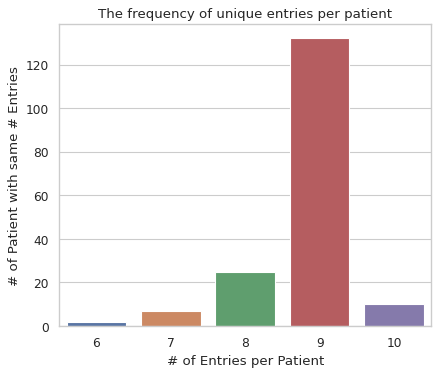

In [12]:
plt.figure(figsize=(6,5), dpi= 80)
sns.barplot(x=unique_count['# of Entries per Patient'], y=unique_count['# of Patient with same # Entries'])
plt.title('The frequency of unique entries per patient')

In [13]:
df_train.columns
#take detail of unique patients: Patient, Age, Sex and SmokingStatus. Other attributes such as 'Weeks', 'FVC', 'Percent',
#are measurement
cols=['Patient','Age','Sex','SmokingStatus']
unique_patient = df_train[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates()
unique_patient.head()

,Patient,Age,Sex,SmokingStatus
0,ID00007637202177411956430,79,Male,Ex-smoker
9,ID00009637202177434476278,69,Male,Ex-smoker
18,ID00010637202177584971671,60,Male,Ex-smoker
27,ID00011637202177653955184,72,Male,Ex-smoker
36,ID00012637202177665765362,65,Male,Never smoked


- 79% of the patients are male and 21% female. 
- the majority of patients are ex-smokers with 67% and patients who never smoke are 28%, current smokers are only 5%
- Ex-smokers 90% are male and 10% are female
- Never smoked 53% male and 47% female
- Current skokers 78% male and 22% female


In [14]:
#calculate the gender distriction in the train dataset
print("Male persentage in dataset: ",df_train[df_train["Sex"]=="Male"].shape[0]*100/len(df_train))
print("Female persentage in dataset: ",df_train[df_train["Sex"]=="Female"].shape[0]*100/len(df_train))

Male persentage in dataset:  79.0187217559716
Female persentage in dataset:  20.981278244028406


In [15]:
#classifying the smoking status 
print("Percent of Ex-smoker: ",df_train[df_train["SmokingStatus"]=="Ex-smoker"].shape[0]*100/len(df_train))
print("Percent of Never a smoker: ",df_train[df_train["SmokingStatus"]=="Never smoked"].shape[0]*100/len(df_train))
print("Percent of Currently smokes: ",df_train[df_train['SmokingStatus']=="Currently smokes"].shape[0]*100/len(df_train))

Percent of Ex-smoker:  67.01097482246611
Percent of Never a smoker:  27.695287282117494
Percent of Currently smokes:  5.293737895416398


In [16]:
df_train[df_train['SmokingStatus']=='Ex-smoker']['Sex'].value_counts()*100/len(df_train[df_train['SmokingStatus']=='Ex-smoker'])

Male      89.691715
Female    10.308285
Name: Sex, dtype: float64

In [17]:
df_train[df_train['SmokingStatus']=='Never smoked']['Sex'].value_counts()*100/len(df_train[df_train['SmokingStatus']=='Never smoked'])

Male      53.379953
Female    46.620047
Name: Sex, dtype: float64

In [18]:
df_train[df_train['SmokingStatus']=='Currently smokes']['Sex'].value_counts()*100/len(df_train[df_train['SmokingStatus']=='Currently smokes'])

Male      78.04878
Female    21.95122
Name: Sex, dtype: float64

Text(0.5, 1.0, 'Ratio of Gender')

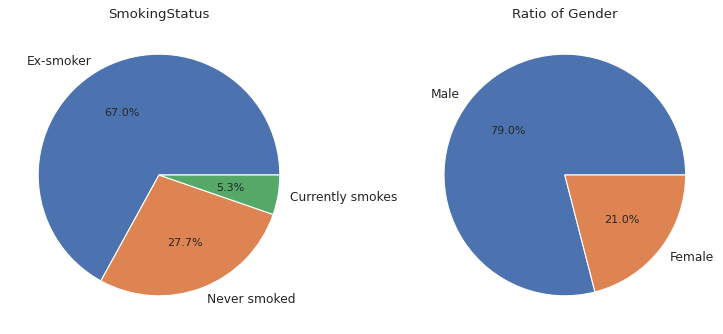

In [19]:
# Draw a pie chart about smoking status
plt.figure(figsize=(12,5), dpi= 80)
plt.subplot(1, 2, 1)
plt.pie(df_train["SmokingStatus"].value_counts(),labels=["Ex-smoker","Never smoked","Currently smokes"],autopct="%.1f%%")
plt.title("SmokingStatus")
# Draw a pie chart about gender.
plt.subplot(1, 2, 2)
plt.pie(df_train["Sex"].value_counts(),labels=["Male","Female"],autopct="%.1f%%")
plt.title("Ratio of Gender")

The age distributed between 49 and 88 with mean 67. Looking at the distribution plot below, uniform with a little swewness to the left.

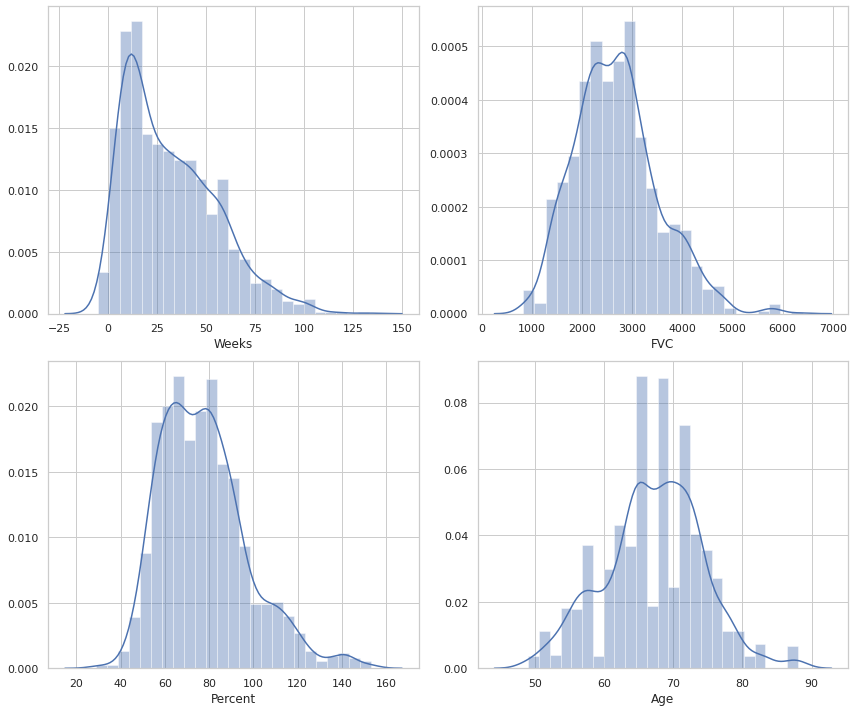

In [20]:
f, axes = plt.subplots(2, 2,figsize=(12, 10), sharex=False)
sns.distplot(df_train['Weeks'], bins=25, ax=axes[0, 0])
sns.distplot(df_train['FVC'], bins=25, ax=axes[0, 1])
sns.distplot(df_train['Percent'], bins=25, ax=axes[1, 0])
sns.distplot(df_train['Age'], bins=25, ax=axes[1, 1])
plt.tight_layout()


Forced vital capacity (FVC) is the recorded lung capacity in ml which is defined as the amount of air that can be forcibly exhaled from your lungs after taking the deepest breath possible, as measured by spirometry.




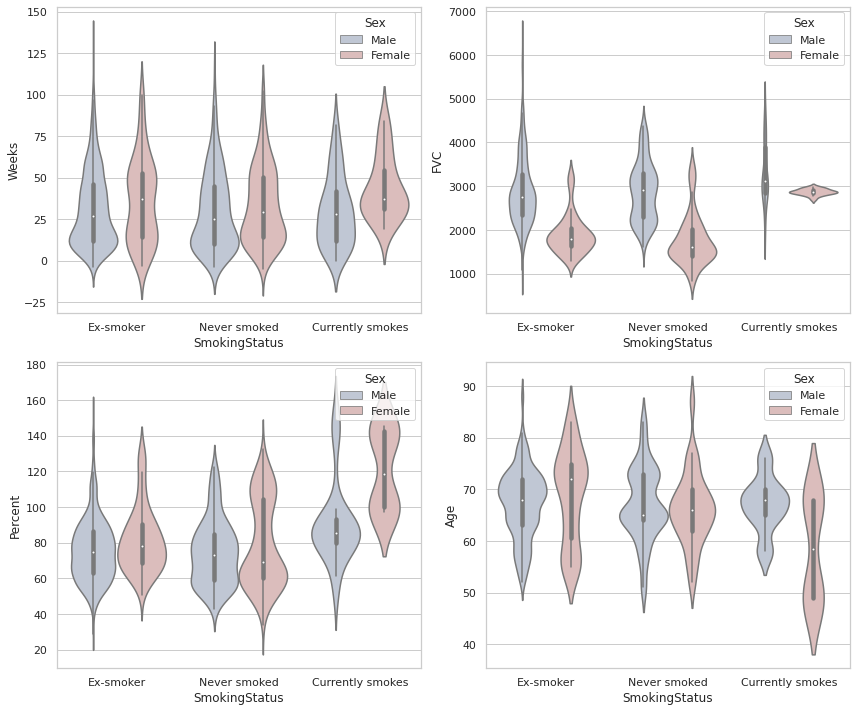

In [21]:
f, axes = plt.subplots(2, 2,figsize=(12, 10), sharex=False)
sns.violinplot(x="SmokingStatus",y="Weeks",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[0, 0])
sns.violinplot(x="SmokingStatus",y="FVC",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[0, 1])
sns.violinplot(x="SmokingStatus",y="Percent",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[1, 0])
sns.violinplot(x="SmokingStatus",y="Age",data=df_train, palette="vlag", hue='Sex',orient='v' , ax=axes[1, 1])
plt.tight_layout()

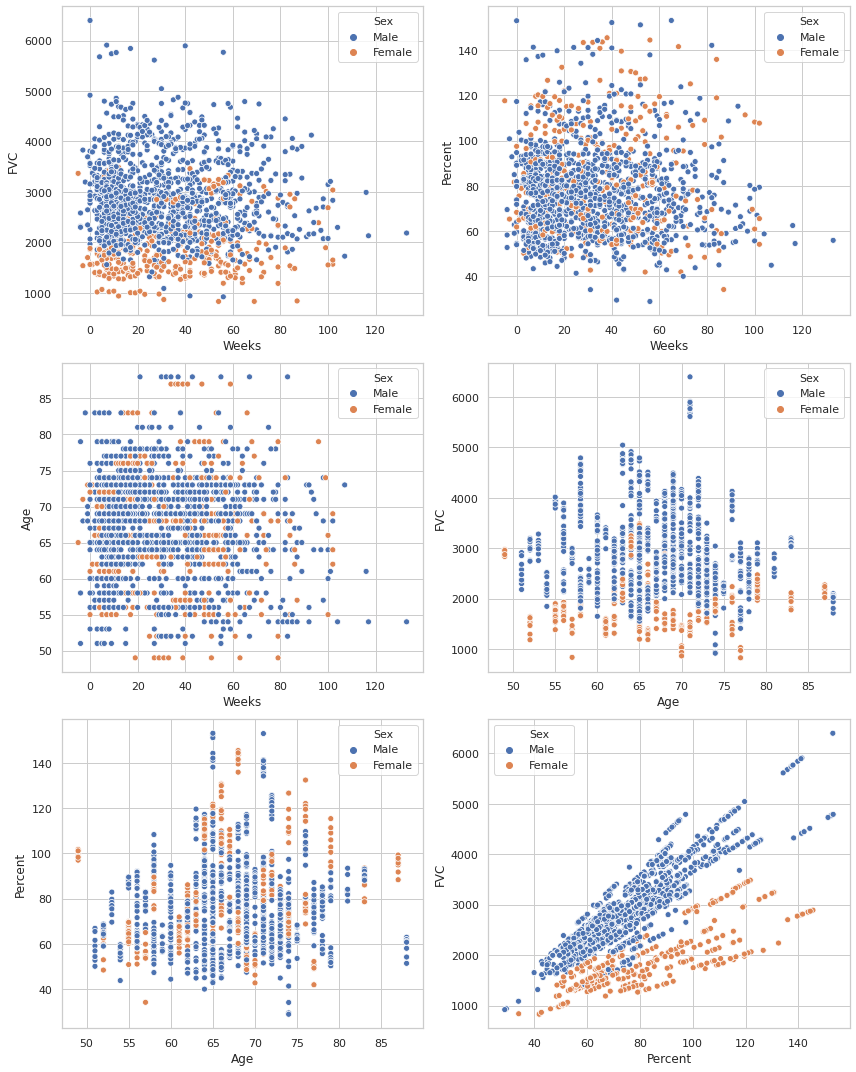

In [22]:
f, axes = plt.subplots(3, 2,figsize=(12, 15), sharex=False)
sns.scatterplot(x='Weeks', y='FVC', data=df_train, hue='Sex', ax=axes[0,0])
sns.scatterplot(x='Weeks', y='Percent', data=df_train, hue='Sex', ax=axes[0,1])
sns.scatterplot(x='Weeks', y='Age', data=df_train, hue='Sex', ax=axes[1,0])
sns.scatterplot(x='Age', y='FVC', data=df_train, hue='Sex', ax=axes[1,1])
sns.scatterplot(x='Age', y='Percent', data=df_train, hue='Sex', ax=axes[2,0])
sns.scatterplot(x='Percent', y='FVC', data=df_train, hue='Sex', ax=axes[2,1])
plt.tight_layout()


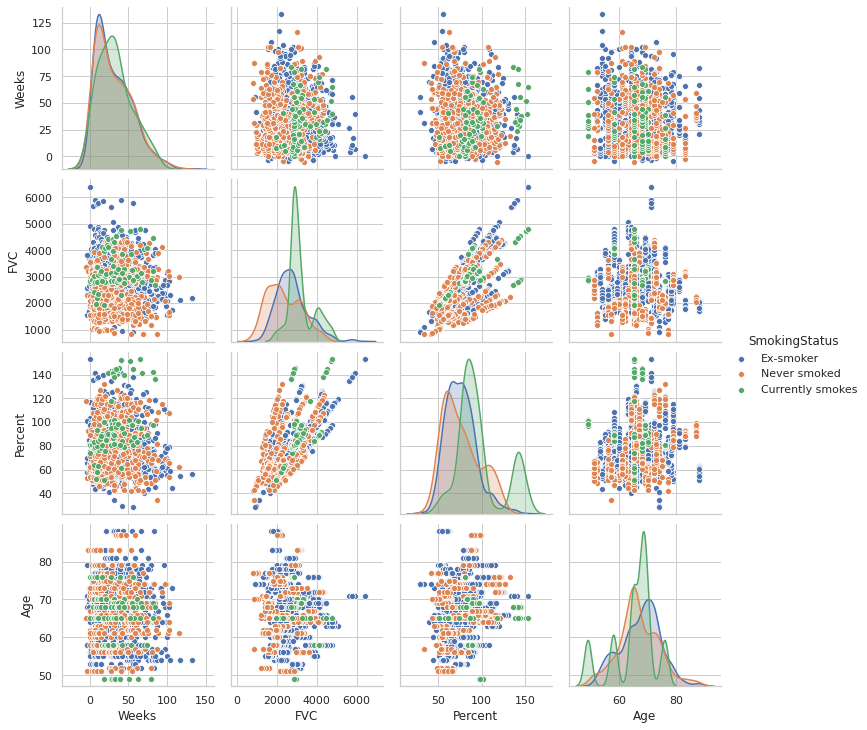

In [23]:
sns.pairplot(df_train, hue='SmokingStatus')

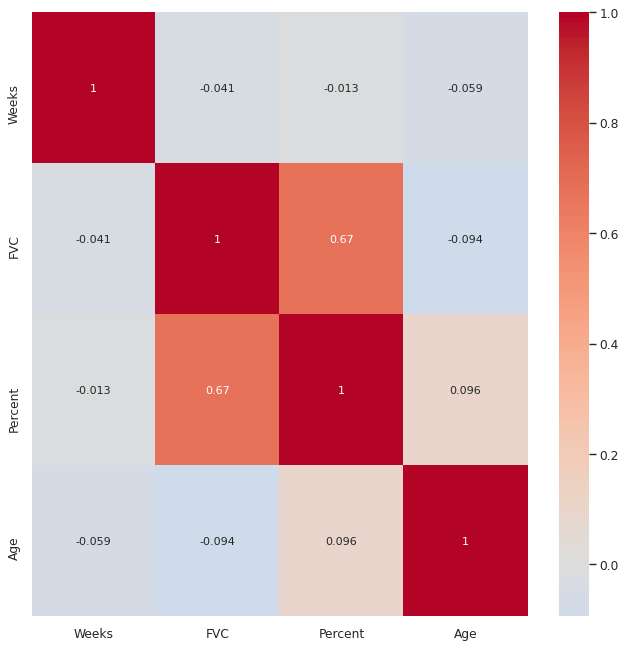

In [24]:
#Correlation using heatmap
plt.figure(figsize=(10,10), dpi= 80)
df_cor=df_train.corr()
hm=sns.heatmap(df_cor, annot=True,center = 0,cmap='coolwarm', cbar=True)


## EDA of DICOM files

The images are in DICOM format. DICOM stands for Digital Imaging and Communications in Medicine. Wikipidea defines DICOM as: it is the standard for the communication and management of medical imaging information and related data. DICOM is most commonly used for storing and transmitting medical images enabling the integration of medical imaging devices such as scanners, servers, workstations, printers, network hardware, and picture archiving and communication systems (PACS) from multiple manufacturers.

In [25]:
#creating path column for dcm files of patient
df_train['Path']=image_train + df_train['Patient']
df_train['dcm count']=0
for i, path in enumerate(df_train['Path']):
  df_train['dcm count'][i]=len(os.listdir(path))

In [26]:
print(round(df_train['dcm count'].max()), 'maximum files/images per patient')
print(round(df_train['dcm count'].mean()), 'average files/images per patient')
print(round(df_train['dcm count'].min()), 'minimum files/images per patient')

1018 maximum files/images per patient
187 average files/images per patient
12 minimum files/images per patient


In [27]:
# view the hidden information of a single DIOCOM file
image_dir = image_train + 'ID00007637202177411956430'
filename = image_dir + "/" + str(1) + ".dcm"
ds = pydicom.dcmread(filename)
print(ds)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12297650151329871895440507938349160734
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.12297650151329871895440507938349160734
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) 

In [28]:
def extract_dicom_meta_data(filename: str) -> Dict:
    # Load image
    
    image_data = pydicom.read_file(filename)
    img=np.array(image_data.pixel_array).flatten()
    row = {
        'Patient': image_data.PatientID,
        'body_part_examined': image_data.BodyPartExamined,
        'image_position_patient': image_data.ImagePositionPatient,
        'image_orientation_patient': image_data.ImageOrientationPatient,
        'photometric_interpretation': image_data.PhotometricInterpretation,
        'rows': image_data.Rows,
        'columns': image_data.Columns,
        'pixel_spacing': image_data.PixelSpacing,
        'window_center': image_data.WindowCenter,
        'window_width': image_data.WindowWidth,
        'modality': image_data.Modality,
        'StudyInstanceUID': image_data.StudyInstanceUID,
        'SeriesInstanceUID': image_data.StudyInstanceUID,
        'StudyID': image_data.StudyInstanceUID, 
        'SamplesPerPixel': image_data.SamplesPerPixel,
        'BitsAllocated': image_data.BitsAllocated,
        'BitsStored': image_data.BitsStored,
        'HighBit': image_data.HighBit,
        'PixelRepresentation': image_data.PixelRepresentation,
        'RescaleIntercept': image_data.RescaleIntercept,
        'RescaleSlope': image_data.RescaleSlope,
        'img_min': np.min(img),
        'img_max': np.max(img),
        'img_mean': np.mean(img),
        'img_std': np.std(img)}

    return row

In [ ]:
train_image_path = '/content/drive/My Drive/OSIC Pulmonary Fibrosis/training'
train_image_files = glob.glob(os.path.join(train_image_path, '*', '*.dcm'))

meta_data_df = []
for filename in tqdm.tqdm(train_image_files):
    try:
        meta_data_df.append(extract_dicom_meta_data(filename))
    except Exception as e:
        continue

In [ ]:
# Convert to a pd.DataFrame from dict
meta_data_df = pd.DataFrame.from_dict(meta_data_df)
meta_data_df.head()

In [ ]:
#let's pickle for later use
meta_data_df.to_pickle("dicom_meta_data.pkl")

In [ ]:
meta_data_df.shape

In [33]:
import pickle
DATA_PATH = "/content/drive/My Drive/dicom_meta_data.pkl"
infile = open(DATA_PATH,'rb')
meta_df = pickle.load(infile)
meta_df.head()

,Patient,body_part_examined,image_position_patient,image_orientation_patient,photometric_interpretation,rows,columns,pixel_spacing,window_center,window_width,modality,StudyInstanceUID,SeriesInstanceUID,StudyID,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleIntercept,RescaleSlope,img_min,img_max,img_mean,img_std
0,ID00423637202312137826377,Chest,"[-188.5, -56.5, 984.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3348,518.435173,510.036957
1,ID00423637202312137826377,Chest,"[-188.5, -56.5, 986.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3271,517.282322,508.945019
2,ID00423637202312137826377,Chest,"[-188.5, -56.5, 985.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3245,517.906448,509.793827
3,ID00423637202312137826377,Chest,"[-188.5, -56.5, 983.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3226,519.452381,509.732317
4,ID00423637202312137826377,Chest,"[-188.5, -56.5, 979.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3168,523.377628,511.021599


In [39]:
#we have 176 unique patients
df_train.Patient.value_counts()

ID00229637202260254240583    10
ID00400637202305055099402    10
ID00167637202237397919352    10
ID00388637202301028491611    10
ID00421637202311550012437    10
                             ..
ID00111637202210956877205     7
ID00128637202219474716089     7
ID00276637202271694539978     7
ID00047637202184938901501     6
ID00267637202270790561585     6
Name: Patient, Length: 176, dtype: int64

In [38]:
#we have 173 unique patients, dmc of 3patients' images lack some attributes 
meta_df.Patient.value_counts()

ID00078637202199415319443    1018
ID00202637202249376026949     825
ID00173637202238329754031     602
ID00180637202240177410333     577
ID00035637202182204917484     574
                             ... 
ID00242637202264759739921      18
ID00126637202218610655908      17
ID00229637202260254240583      17
ID00248637202266698862378      16
ID00165637202237320314458      12
Name: Patient, Length: 173, dtype: int64

In [34]:
train=df_train.drop_duplicates(subset='Patient',keep="first")
meta=meta_df.drop_duplicates(subset='Patient', keep='first')

In [35]:
data=train.merge(meta, on='Patient', how='left')

In [36]:
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Path,dcm count,body_part_examined,image_position_patient,image_orientation_patient,photometric_interpretation,rows,columns,pixel_spacing,window_center,window_width,modality,StudyInstanceUID,SeriesInstanceUID,StudyID,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleIntercept,RescaleSlope,img_min,img_max,img_mean,img_std
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,30,Chest,"[-158.700, -153.500, -69.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512.0,512.0,"[0.652344, 0.652344]",-500.0,-1500.0,CT,2.25.80896671862726099888461805953012988790,2.25.80896671862726099888461805953012988790,2.25.80896671862726099888461805953012988790,1.0,16.0,16.0,15.0,1.0,-1024.0,1.0,-2000.0,2842.0,-1.454884,1137.488858
1,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,394,Chest,"[-171.634766, -333.634766, -44.200001]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,768.0,768.0,"[0.486979, 0.486979]",-500.0,1500.0,CT,2.25.156962683457839326089809785890930019885,2.25.156962683457839326089809785890930019885,2.25.156962683457839326089809785890930019885,1.0,16.0,16.0,15.0,0.0,-1024.0,1.0,0.0,4346.0,591.064126,568.077568
2,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,106,Chest,"[-169.1728515625, -314.1728515625, -798.5]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512.0,512.0,"[0.654296875, 0.654296875]",-500.0,-1500.0,CT,2.25.11726522219678615199208148726917028045,2.25.11726522219678615199208148726917028045,2.25.11726522219678615199208148726917028045,1.0,16.0,12.0,11.0,0.0,-1024.0,1.0,0.0,3135.0,522.350807,535.789915
3,ID00011637202177653955184,6,3326,85.987590,72,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID00012637202177665765362,33,3418,93.726006,65,Male,Never smoked,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,49,Chest,"[-160.0000, -160.0000, 1909.000]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",MONOCHROME2,512.0,512.0,"[0.625, 0.625]",-500.0,-1500.0,CT,2.25.153147783572292318044190524202375230808,2.25.153147783572292318044190524202375230808,2.25.153147783572292318044190524202375230808,1.0,16.0,16.0,15.0,1.0,0.0,1.0,-2048.0,2647.0,-743.294075,828.525457


In [37]:
print("Q: Are there any missing values?", "\n" +
      "A: {}".format(data.isnull().values.any()))


Q: Are there any missing values? 
A: True


In [40]:
data.isnull().sum()

Patient                       0
Weeks                         0
FVC                           0
Percent                       0
Age                           0
Sex                           0
SmokingStatus                 0
Path                          0
dcm count                     0
body_part_examined            3
image_position_patient        3
image_orientation_patient     3
photometric_interpretation    3
rows                          3
columns                       3
pixel_spacing                 3
window_center                 3
window_width                  3
modality                      3
StudyInstanceUID              3
SeriesInstanceUID             3
StudyID                       3
SamplesPerPixel               3
BitsAllocated                 3
BitsStored                    3
HighBit                       3
PixelRepresentation           3
RescaleIntercept              3
RescaleSlope                  3
img_min                       3
img_max                       3
img_mean

In [41]:
data.dropna(axis=0, inplace=True)
print("Q: Are there any missing values?", "\n" +
      "A: {}".format(data.isnull().values.any()))

Q: Are there any missing values? 
A: False


In [43]:
data.shape

(173, 33)